In [125]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import psycopg2
import datetime
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from datetime import timedelta
from scipy import stats
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
%matplotlib inline

def func_lognorm(x,amplitude,mean,std):
    temp1=1/(x*std*np.sqrt(2*np.pi))
    temp2=np.exp(-((np.log(x)-mean)**2)/(2*std**2))
    return amplitude*temp1*temp2

In [126]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

source = "USA_NYT"
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command, conn, params={'source': source})
df_epidemiology=df_epidemiology[df_epidemiology['adm_area_2'].notnull()]

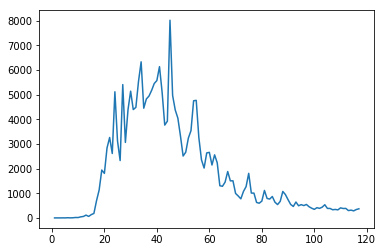

In [127]:
#df_epidemiology=df_epidemiology[(df_epidemiology['date'] <= datetime.date(2020,6,23)) & (df_epidemiology['date'] >= datetime.date(2020,6,13))]

nyc=df_epidemiology[(df_epidemiology['adm_area_1']=='New York')&(df_epidemiology['adm_area_2']=='New York City')]
nyc['confirmed'].sort_values().diff().reset_index(drop=True).plot()

In [128]:
states=df_epidemiology[df_epidemiology['date'] == datetime.date(2020,6,23)].sort_values(ascending=False,by='confirmed').head(50)['adm_area_1'].values
counties=df_epidemiology[df_epidemiology['date'] == datetime.date(2020,6,23)].sort_values(ascending=False,by='confirmed').head(50)['adm_area_2'].values
days_since_first=list()
confirmed_series=list()
model_params=list()
residuals=list()

for i,(state,county) in enumerate(zip(states,counties)):
    print(state,county)
    days_since_first.append((df_epidemiology[(df_epidemiology['adm_area_2']==county)&(df_epidemiology['adm_area_1']==state)].iloc[0]['date']-df_epidemiology[(df_epidemiology['adm_area_2']==county)&(df_epidemiology['adm_area_1']==state)].iloc[-1]['date']).days)
    confirmed_series.append(np.diff(np.flip(df_epidemiology[(df_epidemiology['adm_area_2']==county)&(df_epidemiology['adm_area_1']==state)]['confirmed'].values)))
    popt,pcov=curve_fit(func_lognorm,xdata=list(range(days_since_first[i]))[1::],ydata=confirmed_series[i][1::],maxfev=1000000)
    residuals.append(np.array(confirmed_series[i][1::])-[func_lognorm(x,popt[0],popt[1],popt[2]) for x in list(range(days_since_first[i]))[1::]])
    model_params.append(popt)
    '''
    plt.figure()
    ax=sns.lineplot(x=range(days_since_first[i]),y=confirmed_series[i])
    sns.lineplot(x=list(range(days_since_first[i]))[1::],y=[func_lognorm(x,popt[0],popt[1],popt[2]) for x in list(range(days_since_first[i]))[1::]])
    ax.set_title(state+', '+county)
    '''

New York New York City
California Los Angeles
Illinois Cook
New York Nassau


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


New York Suffolk
New York Westchester
Arizona Maricopa
Florida Miami-Dade
Pennsylvania Philadelphia
Texas Harris


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:822: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


Massachusetts Middlesex
Michigan Wayne
Massachusetts Suffolk
New Jersey Bergen
New Jersey Hudson
New Jersey Essex
Maryland Prince George's
Texas Dallas
New Jersey Passaic
New Jersey Middlesex
Connecticut Fairfield
New Jersey Union
Massachusetts Essex
California Riverside
Maryland Montgomery
Virginia Fairfax
New York Rockland
Rhode Island Providence
Connecticut New Haven
Massachusetts Worcester
Michigan Oakland
Florida Broward
Connecticut Hartford
California San Diego
Nevada Clark
Florida Palm Beach
Indiana Marion
Minnesota Hennepin
California Orange
New York Orange
Wisconsin Milwaukee
District of Columbia District of Columbia
California San Bernardino
New Jersey Ocean
Illinois Lake
Texas Tarrant
Washington King
Utah Salt Lake
North Carolina Mecklenburg
Massachusetts Norfolk


In [129]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()


countrycode = "USA"

sql_command = """SELECT * FROM weather WHERE countrycode=%(countrycode)s ORDER by date DESC"""
df_weather = pd.read_sql(sql_command, conn, params={'countrycode': countrycode})

In [130]:
df_weather.columns

#selected columns 'precip_mean_avg' 'precip_mean_std' 'specific_humidity_mean_avg' 'specific_humidity_mean_std' 'air_temperature_mean_avg' 'air_temperature_mean_std'


Index(['date', 'countrycode', 'gid', 'precip_max_avg', 'precip_max_std',
       'precip_mean_avg', 'precip_mean_std', 'specific_humidity_max_avg',
       'specific_humidity_max_std', 'specific_humidity_mean_avg',
       'specific_humidity_mean_std', 'specific_humidity_min_avg',
       'specific_humidity_min_std', 'short_wave_radiation_max_avg',
       'short_wave_radiation_max_std', 'short_wave_radiation_mean_avg',
       'short_wave_radiation_mean_std', 'air_temperature_max_avg',
       'air_temperature_max_std', 'air_temperature_mean_avg',
       'air_temperature_mean_std', 'air_temperature_min_avg',
       'air_temperature_min_std', 'windgust_max_avg', 'windgust_max_std',
       'windgust_mean_avg', 'windgust_mean_std', 'windgust_min_avg',
       'windgust_min_std', 'windspeed_max_avg', 'windspeed_max_std',
       'windspeed_mean_avg', 'windspeed_mean_std', 'windspeed_min_avg',
       'windspeed_min_std'],
      dtype='object')

In [173]:
precipitation_series=list()
humidity_series=list()
temperature_series=list()

for i,(state,county) in enumerate(zip(states,counties)):
    gids=df_epidemiology[(df_epidemiology['adm_area_1']==state)&(df_epidemiology['adm_area_2']==county)]['gid'].iloc[0]
    precipitation=list()
    humidity=list()
    temperature=list()
    
    for gid in gids:
        if len(df_weather[df_weather['gid']==gid]['precip_mean_avg'].values)==0:
            continue
        precipitation.append(df_weather[df_weather['gid']==gid]['precip_mean_avg'].values)
        humidity.append(list(df_weather[df_weather['gid']==gid]['specific_humidity_mean_avg'].values))
        temperature.append(list(df_weather[df_weather['gid']==gid]['air_temperature_mean_avg'].values))
    
    precipitation=np.mean(np.array(precipitation),axis=0)
    humidity=np.mean(np.array(humidity),axis=0)
    temperature=np.mean(np.array(temperature),axis=0)
    
    precipitation_series.append(list(precipitation))
    humidity_series.append(list(humidity))
    temperature_series.append(list(temperature))
    
lag=5

X_train=np.array([temperature_series[0],precipitation_series[0],humidity_series[0]]).T[::-1][-days_since_first[0]-lag+1:-lag,:]
y_train=residuals[0]

for i,(state,county) in enumerate(zip(states,counties)):
    if i==0:
        continue
    X_train=np.vstack((X_train,np.array([temperature_series[i],precipitation_series[i],humidity_series[i]]).T[::-1][-days_since_first[i]-lag+1:-lag,:]))
    y_train=np.hstack((y_train,residuals[i]))
    continue
    
X_train=np.array(X_train)
y_train=np.array(y_train)

LinearRegression().fit(X_train,y_train).score(X_train,y_train)

0.0010002029961220238

In [174]:
import statsmodels.api as sm
from scipy import stats


X = sm.add_constant(X_train)
est = sm.OLS(y_train, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.888
Date:                Sun, 28 Jun 2020   Prob (F-statistic):              0.129
Time:                        17:29:14   Log-Likelihood:                -37844.
No. Observations:                5660   AIC:                         7.570e+04
Df Residuals:                    5656   BIC:                         7.572e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.7790    158.301      1.041      0.2

0.041920689269204